# Inverse Kinematics for LEAP Hand in Mujoco

In [1]:
import numpy as np
import mujoco
import mujoco.viewer as viewer
import mediapy as media

## Load Model

In [2]:
#Load model
xml = "/home/iitgn-robotics/Saniya/inversekinematics-numerical/mujoco-3.1.6/model/leap hand/index_finger.xml" # add your path
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

## Setup Camera

In [3]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)

# Adjust camera distance
camera.distance = 1  # Distance from the object

# Adjust camera angles
# camera.azimuth = 0  # Horizontal rotation (in degrees)
camera.elevation = -20  # Vertical rotation (negative for downward view)

# Ensure correct elevation to look slightly downward from the side


## Get a test point

In [ ]:
#Put a position of the joints to get a test point
pi = np.pi
data.qpos = [pi/6,0,pi/6,pi/6]

#Initial joint position
qpos0 = data.qpos.copy()

#Step the simulation.
mujoco.mj_forward(model, data)

#Use the last piece as an "end effector" to get a test point in cartesian 
# coordinates
target = data.body('fingertip').xpos
print("Target =>",target)

#Plot results
print("Results")
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
init_point = data.body('fingertip').xpos.copy()
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = qpos0
mujoco.mj_forward(model, data)
result_point = data.body('fingertip').xpos.copy()
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("initial point =>", init_point)
print("Desire point =>", result_point, "\n")

images = {
    'Initial position': target_plot,
    ' Desire end effector position': result_plot,
}

media.show_images(images)

Target => [ 0.0565407   0.0226578  -0.07722874] [ 1.00000000e+00 -3.92523115e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.00000000e+00  3.92523115e-16  1.00000000e+00
  0.00000000e+00]
Results
initial point => [ 0.08210475  0.0226578  -0.0195224 ]
Desire point => [ 0.0565407   0.0226578  -0.07722874] 



Initial position,Desire end effector position

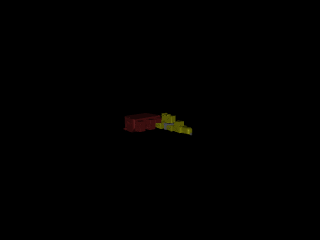
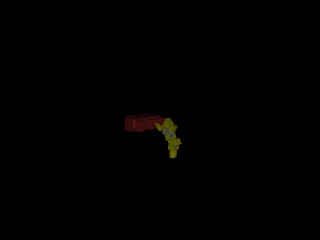

In [7]:
#Put a position of the joints to get a test point
pi = np.pi
data.qpos = [pi/6,0,pi/6,pi/6]

#Initial joint position
qpos0 = data.qpos.copy()

#Step the simulation.
mujoco.mj_forward(model, data)

#Use the last piece as an "end effector" to get a test point in cartesian 
# coordinates
target_pos = data.body('fingertip').xpos
target_mat=data.body('fingertip').xmat
print("Target =>",target_pos,target_mat)

#Plot results
print("Results")
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
init_point_pos = data.body('fingertip').xpos.copy()
init_point_rot = data.body('fingertip').xmat.copy()
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = qpos0
mujoco.mj_forward(model, data)
result_point_pos = data.body('fingertip').xpos.copy()
result_point_rot = data.body('fingertip').xmat.copy()
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("initial point =>", init_point_pos)
print("Desire point =>", result_point_pos, "\n")

images = {
    'Initial position': target_plot,
    ' Desire end effector position': result_plot,
}

media.show_images(images)


In [8]:
class GradientDescentIK:
    def __init__(self,xml_path):
        self.model = mujoco.MjModel.from_xml_path(xml_path)
        self.data = mujoco.MjData(self.model)
        self.jacp = np.zeros((3, self.model.nv))  # translation jacobian
        self.jacr = np.zeros((3, self.model.nv)) 
        self.step_size = 0.5
        self.tol = 0.01
        self.alpha = 0.5
        self.init_q = [0.0, 0.0, 0.0, 0.0]  
    
    def check_joint_limits(self, q):
        """Check if the joints are under or above their limits."""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], min(q[i], self.model.jnt_range[i][1]))


    def calculate(self, goal_pos, goal_rot, bodypart):
        self.data.qpos = self.init_q
        mujoco.mj_forward(self.model, self.data)

        body_id= self.model.body(bodypart).id
        
        # Current pose and orientation
        current_pos = self.data.body(body_id).xpos
        current_rot = self.data.body(body_id).xmat.reshape(3, 3)

        # Position and orientation error
        pos_error = np.subtract(goal_pos, current_pos)
        rot_error = 0.5 * (np.cross(current_rot[:, 0], goal_rot[:, 0]) +
                           np.cross(current_rot[:, 1], goal_rot[:, 1]) +
                           np.cross(current_rot[:, 2], goal_rot[:, 2]))

        # Combine position and orientation errors
        error = np.concatenate([pos_error, rot_error])

        max_iterations = 1000
        iteration = 0

        while np.linalg.norm(error) >= self.tol and iteration < max_iterations:
            # Calculate Jacobian for position and orientation
            mujoco.mj_jac(self.model, self.data, self.jacp, self.jacr, goal_pos, body_id)
            full_jacobian = np.vstack((self.jacp, self.jacr))
            
            # Calculate gradient
            grad = self.alpha * full_jacobian.T @ error
            
            # Compute next step
            self.data.qpos += self.step_size * grad
            
            # Check joint limits
            self.check_joint_limits(self.data.qpos)
            
            # Compute forward kinematics
            mujoco.mj_forward(self.model, self.data)
            
            # Update position and orientation error
            current_pos = self.data.body(body_id).xpos
            current_rot = self.data.body(body_id).xmat.reshape(3, 3)
            pos_error = np.subtract(goal_pos, current_pos)
            rot_error = 0.5 * (np.cross(current_rot[:, 0], goal_rot[:, 0]) +
                               np.cross(current_rot[:, 1], goal_rot[:, 1]) +
                               np.cross(current_rot[:, 2], goal_rot[:, 2]))
            error = np.concatenate([pos_error, rot_error])

            iteration += 1

        if iteration >= max_iterations:
            print("Warning: Maximum iterations reached. The solution may not have converged.")
        
        result = self.data.qpos.copy()
        return result

In [11]:
#Load model
xml = '/home/iitgn-robotics/Saniya/inversekinematics-numerical/mujoco-3.1.6/model/leap hand/index_finger.xml' # add your path
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)

# Set camera position
camera.lookat[:] = np.array([0.0, 0.0, 0.0])  # Point in space the camera is looking at
camera.azimuth = 0              # Horizontal angle in degrees
camera.elevation = 90                     # Vertical angle in degrees
camera.distance = 1                         # Distance from the lookat point
    
#Init variables.
site_name = 'contact_index'
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian
goal = [ -0.06,   0.01,  -0.08]
step_size = 0.5
tol = 0.01
alpha = 0.5
init_q = [0.0, 0.0, 0.0, 0.0]

ik = GradientDescentIK(xml)

#Get desire point
mujoco.mj_resetDataKeyframe(model, data, 1) #reset qpos to initial value
ik.calculate(goal, init_q, site_name) #calculate the q angles

result = data.qpos.copy()

# #Plot results
# print("Results")
# data.qpos = qpos0
# mujoco.mj_forward(model, data)
# renderer.update_scene(data, camera)
# target_plot = renderer.render()

data.qpos = result
mujoco.mj_forward(model, data)
result_point = data.site('contact_index').xpos
renderer.update_scene(data, camera)
result_plot = renderer.render()

# print("testing point =>", target)
print("Gradient Descent result =>", result_point, "\n")

images = {
    # 'Testing point': target_plot,
    'Gradient Descent result': result_plot,
}

media.show_images(images)

KeyError: "Invalid name 'contact_index'. Valid names: ['dip', 'fingertip', 'mcp_joint', 'palm', 'pip', 'world']"